In [2]:
var openDigger = require('../../src/open_digger');
var now = new Date();
var res = now.setMonth(now.getMonth() - 1); // handle new year
var startYear = 2022, startMonth = 1, endYear = now.getFullYear(), endMonth = now.getMonth() + 1;
var forEveryMonth = f => {
    var index = 0;
    for (var y = startYear; y <= endYear; y++)
        for (var m = 1; m <= (y === endYear ? endMonth : startMonth); m++)
            f(y, m, index++);
};

# X-lab Community Analysis Report

This notebook is used to track the members active and influence status in X-lab community.

The result can be used for community measurement and incentive.

The start date for this report is 2022-01-01 and the end date is up-to-date.

## Overview

This part is the history OpenRank trending of all projects in X-lab community.

┌─────────┬─────────────┬─────────────────────────────────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬──────────┬──────────┐
│ (index) │     id      │                name                 │ Y2022M1 │ Y2022M2 │ Y2022M3 │ Y2022M4 │ Y2022M5 │ Y2022M6 │ Y2022M7 │ Y2022M8 │ Y2022M9 │ Y2022M10 │ Y2022M11 │
├─────────┼─────────────┼─────────────────────────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼──────────┼──────────┤
│    0    │ '259035151' │     'hypertrons/hypertrons-crx'     │  4.12   │  4.45   │  5.49   │  5.22   │  3.98   │  7.65   │  8.18   │  6.19   │  6.95   │  13.01   │  15.39   │
│    1    │ '288431943' │       'X-lab2017/open-digger'       │  4.71   │  4.87   │  6.06   │  3.76   │  4.14   │  7.67   │  9.17   │  8.53   │  9.96   │  11.84   │  14.65   │
│    2    │ '461374162' │      'X-lab2017/open-research'      │    0    │    0    │  1.75   │   3.5   │  7.88   │  7.83 

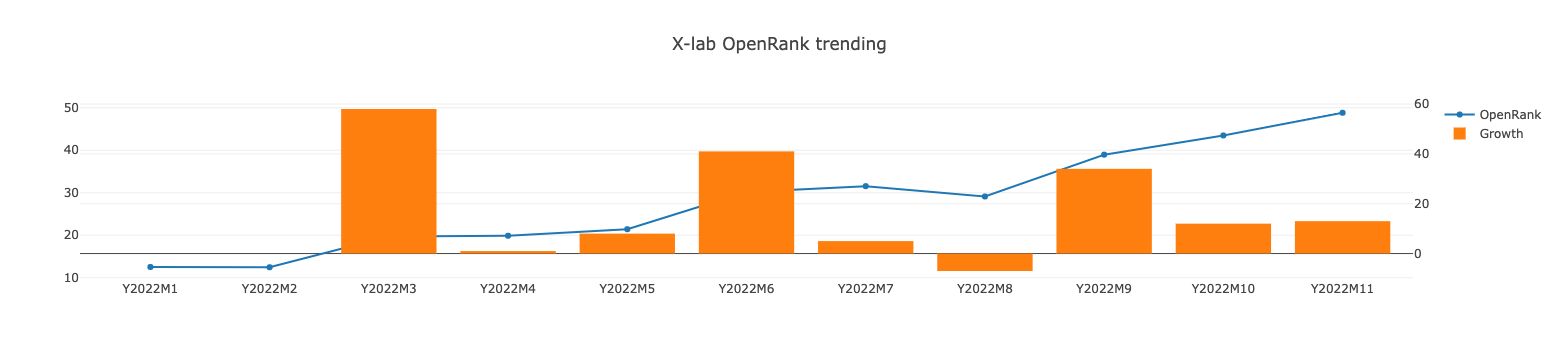

2022.7 based growth: 0.40,0.40,0.62,0.63,0.68,0.96,1.00,0.92,1.23,1.38,1.55


In [3]:
openDigger.index.openrank.getRepoOpenrank({
    repoIds: [288431943, 470364208, 467768946, 461374162, 471252840, 477937218, 428629051, 262909684, 221379769, 259035151, 358757145, 502755745, 508325123, 533339106],
    startYear, startMonth,
    endYear, endMonth, percision: 2,
    groupTimeRange: 'month', limit: -1, order: 'DESC',
}).then(data => {
    var x = [], v = [], g = []; g.push(0);
    forEveryMonth((y, m, index) => {
        var key = `Y${y}M${m}`;
        x.push(key); v.push(0);
        data.forEach(row => { v[index] += (row.openrank[index] ? row.openrank[index] : 0); row[key] = row.openrank[index] ? row.openrank[index] : 0; });
        if (index > 0) g.push(Math.ceil((v[index]-v[index-1])*100/v[index-1]));
    });
    data.forEach(row => { delete row.openrank; delete row.org; });
    console.table(data);
    openDigger.render.plotly([
        { x, y: v, type: 'scatter', name: 'OpenRank' },
        { x, y: g, type: 'bar', yaxis: 'y2', name: 'Growth'}
    ], {
        title: 'X-lab OpenRank trending',
        yaxis2: { overlaying: 'y', side: 'right' }
    });
    console.log(`2022.7 based growth: ${v.map(i => (i/v[6]).toFixed(2))}`);
    fs.writeFileSync('all_data.json', JSON.stringify(data));
});

## OpenRank Distribution

The OpenRank distribution for certain month is calculated by every repo with OpenRank in this month and all the developers' OpenRank in these repos in this month.

The algorithm means:

- If you contribute to a high OpenRank repo, your final OpenRank may higher.
- If you contribute more in any repo, your final OpenRank may higher.
- If you have a high OpenRank in a certain repo, make the repo's OpenRank higher, your OpenRank will be higher.

So please contribute more and contribute to the important repos, or make your own repo important.

In [4]:
var calculateOpenRankDistribution = (y, m, base) => {
    var actors = openDigger.label.getGitHubData([':communities/xlab']).githubUsers;
    var key = `Y${y}M${m}`;
    var repos = JSON.parse(fs.readFileSync('all_data.json').toString()).filter(row => row[key] > 0);
    var actorOpenrankMap = new Map();
    var actorLoginMap = new Map();
    var repoArr = [];
    actors.forEach(id => actorOpenrankMap.set(id, 0));
    Promise.all(repos.map(r => {
        return new Promise(resolve => {
            var sql = `MATCH (u:User) WHERE apoc.any.property(u, 'open_rank_${r.id}_${y}${m}') > 0 RETURN u.id AS id, u.login AS login, apoc.any.property(u, 'open_rank_${r.id}_${y}${m}') AS openrank`;
            openDigger.driver.neo4j.query(sql).then(data => {
                var total = 0;
                var devs = [];
                data.forEach(item => total += item.openrank);
                data.filter(item => actors.includes(item.id)).forEach(item => {
                    actorLoginMap.set(item.id, item.login);
                    var openrank = item.openrank / total;
                    actorOpenrankMap.set(item.id, actorOpenrankMap.get(item.id) + r[key] * openrank);
                    devs.push({login: item.login, openrank });
                });
                if (devs.length > 0)
                    repoArr.push({ name: r.name, openrank: r[key], devsOrigin: devs, devs: devs.sort((a, b) => b.openrank - a.openrank).map(i => `${i.login}(${(i.openrank*100).toFixed(2)}%)`).join(',')});
                resolve();
            });
        });
    })).then(() => {
        var arr = [];
        var total = 0;
        for (var [ id, openrank ] of actorOpenrankMap.entries()) {
            arr.push({login: actorLoginMap.get(id), openrank});
            total += openrank;
        }
        repoArr.sort((a,b) => b.openrank - a.openrank).forEach(r => console.log(r.name, r.openrank, r.devs));
        console.table(arr.map(i => { return { ...i, ratio: (i.openrank*100/total).toFixed(2) + '%', final: Math.round(i.openrank * base / total) } }).filter(i => i.login).sort((a, b) => b.openrank - a.openrank));
        var detail = {};
        if (fs.existsSync('./detail.json')) detail = JSON.parse(fs.readFileSync('./detail.json').toString());
        detail[`${y}-${m}`] = {
            total: arr.filter(i => i.login).sort((a, b) => b.openrank - a.openrank),
            detail: repoArr.map(r => { return { name: r.name, openrank: r.openrank, actors: r.devsOrigin }; }),
        }
        fs.writeFileSync('./detail.json', JSON.stringify(detail));
    });
};

## The OpenRank distibution

In [9]:
calculateOpenRankDistribution(2022, 6, 10000);

X-lab2017/open-research 7.83 will-ww(35.78%),birdflyi(19.68%),xiaoya-yaya(11.38%),frank-zsy(6.83%),bifenglin(5.55%),BenS-Move(4.88%),zhuxiangning(4.08%),kongzhongsanbu(3.03%),AliceCodeZhang(2.82%),tyn1998(2.06%),wengzhenjie(1.61%),gymgym1212(0.95%),longyanz(0.72%)
X-lab2017/open-digger 7.67 frank-zsy(62.99%),xiaoya-yaya(7.71%),Best-Eminem(0.97%),xgdyp(0.86%),gymgym1212(0.83%),tyn1998(0.59%),bifenglin(0.59%),wengzhenjie(0.22%),birdflyi(0.22%),kongzhongsanbu(0.22%),zhicheng-ning(0.22%),chunchill(0.22%),soobun(0.22%),wangleo61(0.22%)
hypertrons/hypertrons-crx 7.65 tyn1998(62.86%),zhicheng-ning(4.01%),wxharry(3.20%),xgdyp(2.96%),frank-zsy(2.44%),will-ww(0.61%)
X-lab2017/open-leaderboard 2.19 gymgym1212(82.47%),will-ww(10.74%),tyn1998(2.04%),frank-zsy(1.22%)
X-lab2017/open-wonderland 1.85 will-ww(30.01%),xiaoya-yaya(25.91%),soobun(10.87%),xgdyp(9.39%),tyn1998(9.32%),gymgym1212(5.95%),zhicheng-ning(4.30%),zhuxiangning(4.26%)
X-lab2017/open-perf 0.93 bifenglin(45.05%),will-ww(39.54%),frank-zs

In [10]:
calculateOpenRankDistribution(2022, 7, 10000);

X-lab2017/open-digger 9.17 frank-zsy(56.46%),yoyo-wu98(7.85%),longyanz(3.68%),xiaoya-yaya(2.40%),Best-Eminem(1.30%),xgdyp(0.93%),zhuxiangning(0.90%),zhicheng-ning(0.31%)
hypertrons/hypertrons-crx 8.18 tyn1998(65.41%),wxharry(10.15%),xgdyp(3.54%),zhicheng-ning(3.06%),frank-zsy(1.68%),will-ww(1.04%)
X-lab2017/open-wonderland 5.46 will-ww(42.31%),bifenglin(21.37%),xiaoya-yaya(10.84%),xgdyp(2.69%),frank-zsy(2.67%),wangleo61(2.55%),kongzhongsanbu(1.88%),tyn1998(1.85%),birdflyi(1.48%),yoyo-wu98(1.48%),longyanz(1.42%),zhicheng-ning(1.31%),gymgym1212(1.03%),BenS-Move(1.02%)
X-lab2017/open-research 3.71 will-ww(42.80%),bifenglin(30.87%),yoyo-wu98(7.58%),xgdyp(2.00%)
X-lab2017/open-leaderboard 1.97 gymgym1212(69.79%),will-ww(30.21%)
OpenEduTech/EduTechResearch 0.7 soobun(65.71%),will-ww(20.56%),AliceCodeZhang(13.73%)
X-lab2017/open-perf 0.48 bifenglin(57.97%),will-ww(42.03%)
┌─────────┬──────────────────┬─────────────────────┬──────────┬───────┐
│ (index) │      login       │      openrank      

In [11]:
calculateOpenRankDistribution(2022, 8, 10000);

X-lab2017/open-digger 8.53 frank-zsy(47.13%),Best-Eminem(10.80%),longyanz(5.88%),xiaoya-yaya(5.22%),PureNatural(4.71%)
X-lab2017/open-wonderland 6.82 xiaoya-yaya(26.82%),will-ww(18.17%),bifenglin(12.70%),wangleo61(7.95%),zhicheng-ning(5.61%),tyn1998(5.55%),birdflyi(5.42%),xgdyp(3.91%)
hypertrons/hypertrons-crx 6.19 tyn1998(34.13%),wxharry(22.78%),frank-zsy(5.93%)
X-lab2017/open-research 3.16 will-ww(100.00%)
X-lab2017/open-perf 0.71 will-ww(68.94%),bifenglin(31.06%)
OpenEduTech/EduTechResearch 0.61 AliceCodeZhang(100.00%)
┌─────────┬──────────────────┬─────────────────────┬──────────┬───────┐
│ (index) │      login       │      openrank       │  ratio   │ final │
├─────────┼──────────────────┼─────────────────────┼──────────┼───────┤
│    0    │    'will-ww'     │  4.888786050715672  │ '23.81%' │ 2381  │
│    1    │   'frank-zsy'    │  4.387478241061516  │ '21.37%' │ 2137  │
│    2    │    'tyn1998'     │  2.491401091785214  │ '12.13%' │ 1213  │
│    3    │  'xiaoya-yaya'   │  2.273789

In [12]:
calculateOpenRankDistribution(2022, 9, 12300);

X-lab2017/open-digger 9.96 frank-zsy(42.46%),xgdyp(10.95%),Best-Eminem(6.84%),zhicheng-ning(4.46%),PureNatural(1.54%),will-ww(0.51%),tyn1998(0.48%),BenS-Move(0.30%),wxharry(0.30%),AliceCodeZhang(0.30%),tvbboy(0.30%)
X-lab2017/open-research 8.01 xiaoya-yaya(33.05%),frank-zsy(19.09%),will-ww(15.73%),xgdyp(6.32%),bifenglin(3.79%),zhicheng-ning(3.59%),wengzhenjie(1.23%),gymgym1212(1.23%),birdflyi(1.23%),longyanz(1.23%),yoyo-wu98(1.23%),wj23027(1.23%),lhbvvvvv(1.23%),andyhuang18(1.23%),lucky-xmyu(1.23%)
hypertrons/hypertrons-crx 6.95 tyn1998(30.10%),wxharry(25.51%),frank-zsy(3.60%),zhicheng-ning(1.73%)
X-lab2017/open-wonderland 5.18 will-ww(48.75%),bifenglin(26.28%),xgdyp(12.71%),tyn1998(12.26%)
OpenEduTech/EduTechResearch 3.17 AliceCodeZhang(43.88%),will-ww(12.70%),lijinlus(10.57%),foursevenlove(7.90%),wj23027(2.17%),lucky-xmyu(2.17%)
OpenEduTech/OpenEduKG 2.5 will-ww(21.71%),tvbboy(20.77%),blackburnnnn(19.65%),AliceCodeZhang(2.28%)
┌─────────┬──────────────────┬──────────────────────┬────

In [13]:
calculateOpenRankDistribution(2022, 10, 13800);

hypertrons/hypertrons-crx 13.01 tyn1998(30.27%),andyhuang18(13.62%),wxharry(10.68%),wj23027(5.02%),frank-zsy(4.60%),Zzzzzhuzhiwei(4.42%),zhicheng-ning(3.57%),xgdyp(1.31%),will-ww(0.42%)
X-lab2017/open-digger 11.84 xgdyp(23.74%),frank-zsy(22.20%),zhicheng-ning(9.85%),yoyo-wu98(5.88%),will-ww(3.82%),lhbvvvvv(3.41%),tyn1998(1.27%),bifenglin(1.11%),xiaoya-yaya(0.50%),Zzzzzhuzhiwei(0.50%),19883235(0.22%),Kx-Chen-99(0.22%),betaberry(0.22%),foursevenlove(0.22%),lijinlus(0.22%),blackburnnnn(0.22%)
X-lab2017/open-research 7.69 xiaoya-yaya(33.76%),bifenglin(23.21%),will-ww(22.72%),birdflyi(7.23%),PureNatural(3.92%),xgdyp(3.83%),tyn1998(2.63%),frank-zsy(1.70%),wangleo61(1.01%)
OpenEduTech/EduTechResearch 4.19 foursevenlove(36.66%),19883235(23.14%),AliceCodeZhang(15.52%),Kx-Chen-99(9.52%),lijinlus(5.96%),will-ww(4.82%),zhicheng-ning(1.24%),tyn1998(0.95%)
OpenEduTech/OpenEduKG 2.15 tvbboy(45.43%),blackburnnnn(20.59%),will-ww(13.28%)
X-lab2017/open-wonderland 2.13 will-ww(40.73%),bifenglin(37.86%),z

In [5]:
calculateOpenRankDistribution(2022, 11, 15500);

hypertrons/hypertrons-crx 15.39 tyn1998(31.14%),frank-zsy(8.85%),andyhuang18(8.31%),wj23027(6.96%),Zzzzzhuzhiwei(6.10%),wxharry(5.94%),will-ww(3.09%),zhicheng-ning(1.06%),lhbvvvvv(0.63%),xgdyp(0.53%)
X-lab2017/open-digger 14.65 frank-zsy(37.28%),xgdyp(29.39%),longyanz(4.36%),zhicheng-ning(2.48%),will-ww(1.83%),Best-Eminem(0.70%),lhbvvvvv(0.66%),lucky-xmyu(0.62%),bifenglin(0.57%),birdflyi(0.17%),xiaoya-yaya(0.09%)
OpenEduTech/EduTechResearch 5.87 foursevenlove(22.03%),19883235(18.46%),AliceCodeZhang(12.02%),lijinlus(11.38%),Kx-Chen-99(7.63%),will-ww(4.41%)
X-lab2017/open-research 5.87 yoyo-wu98(20.66%),bifenglin(17.78%),tyn1998(13.80%),birdflyi(10.93%),xiaoya-yaya(9.74%),will-ww(7.79%),zhicheng-ning(6.55%),xgdyp(6.15%),longyanz(4.17%)
X-lab2017/open-wonderland 3.62 zhicheng-ning(29.77%),bifenglin(22.46%),will-ww(17.42%),tyn1998(11.74%),PureNatural(11.27%)
OpenEduTech/OpenEduKG 1.5 blackburnnnn(57.47%),tvbboy(42.53%)
X-lab2017/open-perf 0.55 bifenglin(72.63%),will-ww(27.37%)
X-lab2017/op